### Período 1

#### Importações

In [1]:
import pandas as pd
import re
import emoji
import nltk
import numpy as np
import string
from nltk.corpus import stopwords

stop_words_pt = set(stopwords.words('portuguese'))
punctuation = set(string.punctuation)


nltk.download('punkt')      # clássico
nltk.download('punkt_tab')  # novo recurso exigido

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import os

import networkx as nx

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nasci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nasci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Análises iniciais

In [2]:
df = pd.read_csv("P1/dataset_zap_1.csv", low_memory=False)

df = df.dropna(subset=["text_content_anonymous"]).copy()
df = df.reset_index(drop=True)

### Normalização e limpeza do texto

O WhatsApp tem vários tipos de ruído:

emojis

figurinhas convertidas em tokens

URLs

risadas (“kkkk”, “rsrsrs”)

stopwords sociais (“bom dia”, “blz”, “oq”, “tá”, etc.)

pontuação repetida

mensagens de sistema (“mensagem apagada”)

números irrelevantes

tokens como “imagem”, “áudio”, “vídeo”

In [3]:
# Stopwords complementares específicas para WhatsApp
custom_stopwords = {
    # cumprimentos / fórmulas sociais
    "bom", "dia",
    "boa", "tarde",
    "noite", "boa", "noite",
    "olá", "oi", "ola", "tchau",

    # risadas / interjeições
    "kk", "kkk", "kkkk", "kkkkk",
    "rs", "rsrs", "rsrsrs",
    "aff", "eita", "oxi", "oxe",

    # WhatsApp / mídia
    "imagem", "figura", "sticker",
    "áudio", "audio", "vídeo", "video",
}

# União das stopwords padrão + complementares
stop_words_total = stop_words_pt | custom_stopwords

punctuation = set(string.punctuation)


In [4]:
def preprocess_text(text):
    """
    1) Lowercase
    2) Mantém emojis e URLs
    3) Normaliza emojis para texto (:smiling_face:)
    4) Tokenização universal do NLTK (sem depender do idioma)
    5) Remove stopwords e pontuação simples
    """
    # lowercase
    text = str(text).lower()
    
    # normalizar emojis
    text = emoji.demojize(text)
    
    # tokenizar (universal tokenizer)
    tokens = nltk.word_tokenize(text)
    
    tokens_clean = []
    for token in tokens:

        # remover pontuação simples
        if token in punctuation:
            continue
        
        # remover stopwords
        if token in stop_words_total:
            continue

        # manter URLs, emojis, números e tokens curtos
        tokens_clean.append(token)
    
    return tokens_clean

In [5]:
# 1. remover mensagens sem texto original
df = df.dropna(subset=['text_content_anonymous']).reset_index(drop=True)

# 2. preprocessamento
df['tokens_preprocessed'] = df['text_content_anonymous'].apply(preprocess_text)

# 3. gerar clean_text
df['clean_text'] = df['tokens_preprocessed'].apply(lambda x: " ".join(x))

# 4. remover mensagens cujo texto limpo ficou vazio
df = df[df['clean_text'].str.strip() != ""].reset_index(drop=True)

print("Mensagens restantes após limpeza:", df.shape)
print(df[['text_content_anonymous', 'tokens_preprocessed', 'clean_text']].head(10))

df.to_csv("dataset_zap_1_preprocessado.csv", index=False)


Mensagens restantes após limpeza: (259650, 35)
                              text_content_anonymous  \
0  👆 *O PIB DECOLA NOVAMENTE!*\n\n*O Ministério d...   
1  👆 *O PIB DECOLA NOVAMENTE!*\n\n*O Ministério d...   
2                       https://youtu.be/4Kr2KRp6pMk   
3  https://m.facebook.com/story.php?story_fbid=pf...   
4  *Esta notícia me deixa triste!*\nhttps://kwai-...   
5  Urgente: Pesquisa Brasmarket aponta vitória de...   
6  https://www.facebook.com/marcelo.calderaro.90/...   
7  https://youtu.be/9St9wUrpU_c\n\n🇧🇷🇧🇷🇧🇷🌿🌿🌿🇧🇷🇧🇷🇧...   
8  👆 *BIOMETRIA NAS URNAS!*\n\n*O presidente do T...   
9  👆 *BIOMETRIA NAS URNAS!*\n\n*O presidente do T...   

                                 tokens_preprocessed  \
0  [backhand_index_pointing_up, pib, decola, nova...   
1  [backhand_index_pointing_up, pib, decola, nova...   
2                    [https, //youtu.be/4kr2krp6pmk]   
3  [https, //m.facebook.com/story.php, story_fbid...   
4  [notícia, deixa, triste, https, //kwai-video.c...   


In [6]:
texts = df["clean_text"].astype(str).tolist()
times = df["date_message"].tolist()
N = len(df)

In [7]:
# garantir que date_message é datetime e não string
df = df.dropna(subset=["date_message"]).copy()
df["date_message"] = pd.to_datetime(df["date_message"], errors="coerce")

# remover linhas com data inválida
df = df.dropna(subset=["date_message"]).reset_index(drop=True)

# ordenar no tempo (ESSENCIAL para janela temporal)
df = df.sort_values("date_message").reset_index(drop=True)

print("Depois de filtrar datas válidas e ordenar:", df.shape)

# agora sim, criar texts/times/N
texts = df["clean_text"].astype(str).tolist()
times = df["date_message"].tolist()
N = len(df)


Depois de filtrar datas válidas e ordenar: (259650, 35)


### verificar similaridade

In [8]:
print("\n[ETAPA 2] Gerando representação TF-IDF (com IDF embutido)...")

# garantir inputs
texts = df["clean_text"].astype(str).tolist()
times = df["date_message"].tolist()
N = len(df)

# Vetorização TF-IDF (IDF embutido)
vectorizer = TfidfVectorizer(min_df=2)
X = vectorizer.fit_transform(texts)

print("Matriz TF-IDF gerada:", X.shape)

# salvar valores de IDF para documentação
idf_df = pd.DataFrame({
    "term": vectorizer.get_feature_names_out(),
    "idf": vectorizer.idf_
}).sort_values(by="idf", ascending=False)

idf_df.to_csv("valores_idf_tfidf.csv", index=False, encoding="utf-8")
print("Tabela de IDF salva em 'valores_idf_tfidf.csv'.")


# ============================================
# 3. FUNÇÃO PARA RODAR UM EXPERIMENTO
# ============================================

def run_experiment(k, window_seconds):
    results = []

    for i in range(N - k):      # otimização
        vec_i = X[i]
        t_i  = times[i]

        for d in range(1, k + 1):
            j = i + d

            t_j = times[j]
            delta_t = (t_j - t_i).total_seconds()

            if delta_t < 0:
                continue
            if delta_t > window_seconds:
                break

            sim_ij = float(vec_i.dot(X[j].T)[0, 0])

            results.append({
                "idx_i": i,
                "idx_j": j,
                "date_i": t_i,
                "date_j": t_j,
                "delta_t_seconds": delta_t,
                "similarity": sim_ij,
                "k": k,
                "window_seconds": window_seconds,
            })

    return pd.DataFrame(results)


# ============================================
# 4. EXPERIMENTOS + CSVs + CCDF + PDF
# ============================================

ks = [2, 5, 10]
windows = [10, 30, 60, 90]
limiar_sim = 0.7
max_dt_pdf = 10

summary_rows = []

def gerar_ccdf(df_exp, k, win):
    df_exp = df_exp.copy()
    df_exp["offset"] = df_exp["idx_j"] - df_exp["idx_i"]
    df_high = df_exp[df_exp["similarity"] >= limiar_sim]

    if df_high.empty:
        print("Nenhum par com similaridade alta para CCDF.")
        return

    plt.figure(figsize=(7,5))

    for offset in range(1, k+1):
        sub = df_high[df_high["offset"] == offset]
        if len(sub) == 0:
            continue

        ts = np.sort(sub["delta_t_seconds"])
        ccdf = 1 - np.arange(1, len(ts)+1) / len(ts)

        plt.loglog(ts, ccdf, label=f"+{offset}")

    plt.xlabel("Time Interval (seconds)")
    plt.ylabel("CCDF")
    plt.title(f"CCDF — Similarity ≥ {limiar_sim} (k={k}, window={win}s)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"CCDF_k{k}_win{win}.png", dpi=300)
    plt.close()


def gerar_pdf_similaridade(df_exp, k, win):
    df_short = df_exp[df_exp["delta_t_seconds"] <= max_dt_pdf]
    if df_short.empty:
        print("Nenhum par com Δt <= max_dt_pdf para PDF.")
        return

    sims = df_short["similarity"]
    hist, edges = np.histogram(sims, bins=np.linspace(0,1,20), density=True)
    centers = (edges[:-1] + edges[1:]) / 2

    plt.figure(figsize=(6,4))
    plt.semilogy(centers, hist, marker="o")
    plt.xlabel("Text Similarity")
    plt.ylabel("PDF")
    plt.title(f"PDF — Pairs with Δt ≤ {max_dt_pdf}s (k={k}, window={win}s)")
    plt.tight_layout()
    plt.savefig(f"PDF_k{k}_win{win}.png", dpi=300)
    plt.close()


# LOOP DOS EXPERIMENTOS
for k in ks:
    for win in windows:
        print(f"\n>>> Rodando experimento k={k}, janela={win}s")
        
        df_exp = run_experiment(k, win)
        print("Pares analisados:", len(df_exp))

        if len(df_exp) == 0:
            continue

        # Estatísticas resumidas
        summary_rows.append({
            "k": k,
            "window_seconds": win,
            "num_pairs": len(df_exp),
            "mean_similarity": df_exp["similarity"].mean(),
            "median_similarity": df_exp["similarity"].median(),
            "p90_similarity": df_exp["similarity"].quantile(0.90),
            "max_similarity": df_exp["similarity"].max(),
        })

        df_exp.to_csv(f"similaridade_k{k}_win{win}s.csv", index=False)
        gerar_ccdf(df_exp, k, win)
        gerar_pdf_similaridade(df_exp, k, win)


# RESUMO FINAL
df_summary = pd.DataFrame(summary_rows)
df_summary.to_csv("resumo_experimentos_similaridade.csv", index=False)
print("\nResumo completo salvo em resumo_experimentos_similaridade.csv")
print(df_summary)


[ETAPA 2] Gerando representação TF-IDF (com IDF embutido)...
Matriz TF-IDF gerada: (259650, 87379)
Tabela de IDF salva em 'valores_idf_tfidf.csv'.

>>> Rodando experimento k=2, janela=10s
Pares analisados: 235779

>>> Rodando experimento k=2, janela=30s
Pares analisados: 385693

>>> Rodando experimento k=2, janela=60s
Pares analisados: 458243

>>> Rodando experimento k=2, janela=90s
Pares analisados: 484209

>>> Rodando experimento k=5, janela=10s
Pares analisados: 337940

>>> Rodando experimento k=5, janela=30s
Pares analisados: 672570

>>> Rodando experimento k=5, janela=60s
Pares analisados: 949392

>>> Rodando experimento k=5, janela=90s
Pares analisados: 1078210

>>> Rodando experimento k=10, janela=10s
Pares analisados: 409696

>>> Rodando experimento k=10, janela=30s
Pares analisados: 835669

>>> Rodando experimento k=10, janela=60s
Pares analisados: 1358792

>>> Rodando experimento k=10, janela=90s
Pares analisados: 1718386

Resumo completo salvo em resumo_experimentos_similar

### Conjunto coordenado

In [9]:
# carregar o experimento ideal
df10_10 = pd.read_csv("P1/similaridade_k10_win10s.csv")

print("Total de pares no experimento:", len(df10_10))

# ================================
# FILTRAR PARES COORDENADOS
# ================================
limiar_sim = 0.7
max_dt = 10

df_coord = df10_10[
    (df10_10["similarity"] >= limiar_sim) &
    (df10_10["delta_t_seconds"] <= max_dt)
].copy()

print("Total de pares coordenados encontrados:", len(df_coord))

# salvar CSV do conjunto coordenado
df_coord.to_csv("conjunto_coordenado_mensagens.csv", index=False, encoding="utf-8")
print("Arquivo salvo: conjunto_coordenado_mensagens.csv")


Total de pares no experimento: 410773
Total de pares coordenados encontrados: 78259
Arquivo salvo: conjunto_coordenado_mensagens.csv


### Rede Mensagem - Mensagem

In [10]:
# ================================
# 1. Carregar conjunto coordenado
# ================================
df_coord = pd.read_csv("conjunto_coordenado_mensagens.csv")
print("Pares coordenados:", len(df_coord))

# ================================
# 2. Criar grafo
# ================================
G = nx.Graph()

for _, row in df_coord.iterrows():
    i = int(row["idx_i"])
    j = int(row["idx_j"])
    sim = float(row["similarity"])
    dt = float(row["delta_t_seconds"])

    if G.has_edge(i, j):
        G[i][j]["weight"] += 1
        # opcional: guardar similaridade máxima / mínima
        G[i][j]["max_similarity"] = max(G[i][j]["max_similarity"], sim)
        G[i][j]["min_delta_t"] = min(G[i][j]["min_delta_t"], dt)
    else:
        G.add_edge(
            i, j,
            weight=1,
            similarity=sim,
            max_similarity=sim,
            delta_t=dt,
            min_delta_t=dt
        )

print("Nós na rede:", G.number_of_nodes())
print("Arestas na rede:", G.number_of_edges())

# ================================
# 3. Identificar Componentes Conectados
# ================================
components = sorted(nx.connected_components(G), key=len, reverse=True)
print(f"Número de componentes coordenados: {len(components)}")

# obter o maior componente coordenado (cluster principal)
largest_comp = components[0]
print(f"Tamanho do maior cluster coordenado: {len(largest_comp)} mensagens")

# salvar mensagens desse cluster
df_largest = pd.DataFrame({"message_idx": list(largest_comp)})
df_largest.to_csv("cluster_coordenado_principal.csv", index=False)
print("Cluster coordenado principal salvo em cluster_coordenado_principal.csv")

# ================================
# 4. Salvar Grafo para Gephi / análise externa
# ================================
nx.write_gexf(G, "rede_coordenada.gexf")
print("Grafo coordenado salvo como rede_coordenada.gexf (compatível com Gephi).")


Pares coordenados: 78259
Nós na rede: 36509
Arestas na rede: 78259
Número de componentes coordenados: 12182
Tamanho do maior cluster coordenado: 874 mensagens
Cluster coordenado principal salvo em cluster_coordenado_principal.csv
Grafo coordenado salvo como rede_coordenada.gexf (compatível com Gephi).


In [11]:
df_msgs = pd.read_csv("P1/dataset_zap_1.csv")  # ou a versão com clean_text
df_msgs = df_msgs.reset_index().rename(columns={"index": "idx"})

df_largest = pd.DataFrame({"idx": list(largest_comp)})

cluster_msgs = df_largest.merge(df_msgs, on="idx", how="left")

cluster_msgs.to_csv("cluster_coordenado_principal_com_texto.csv", index=False)

C:\Users\nasci\AppData\Local\Temp\ipykernel_3204\3312706711.py:1: DtypeWarning: Columns (11,15,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_msgs = pd.read_csv("P1/dataset_zap_1.csv")  # ou a versão com clean_text


In [17]:
import pandas as pd
import networkx as nx

# 1. Carregar conjunto coordenado e df preprocessado
df_coord = pd.read_csv("conjunto_coordenado_mensagens.csv")
df_msgs  = pd.read_csv("dataset_zap_1_preprocessado.csv")

# 2. RECRIAR o índice que foi usado como idx_i / idx_j
#    (0, 1, 2, ..., N-1)
df_msgs = df_msgs.reset_index().rename(columns={"index": "msg_idx"})

# agora você tem:
# - coluna msg_idx  -> equivalente ao idx_i / idx_j
# - coluna id       -> ID original da coleta (se quiser usar depois)
# - coluna id_member_anonymous -> usuário

# 3. Criar dicionário posição -> usuário
df_users = df_msgs[["msg_idx", "id_member_anonymous"]].copy()
msg_to_user = dict(zip(df_users["msg_idx"], df_users["id_member_anonymous"]))

# 4. Construir grafo usuário↔usuário
G_users = nx.Graph()

pares_ok = 0
falhas = 0

for _, row in df_coord.iterrows():
    i = int(row["idx_i"])
    j = int(row["idx_j"])

    if i not in msg_to_user or j not in msg_to_user:
        falhas += 1
        continue

    u = msg_to_user[i]
    v = msg_to_user[j]

    if u == v:
        continue

    pares_ok += 1

    if G_users.has_edge(u, v):
        G_users[u][v]["weight"] += 1
    else:
        G_users.add_edge(u, v, weight=1)

print("Pares coordenados no CSV:", len(df_coord))
print("Pares mapeados para usuários distintos:", pares_ok)
print("Falhas de mapeamento (índices não encontrados):", falhas)
print("Usuários na rede:", G_users.number_of_nodes())
print("Arestas (coordenação usuário↔usuário):", G_users.number_of_edges())


Pares coordenados no CSV: 78259
Pares mapeados para usuários distintos: 70371
Falhas de mapeamento (índices não encontrados): 20
Usuários na rede: 5896
Arestas (coordenação usuário↔usuário): 45770


### Rede usuário → usuário (descobrir quem coordena)

In [22]:
import pandas as pd
import networkx as nx

# =======================
# 1. Carregar dados
# =======================
df_coord = pd.read_csv("conjunto_coordenado_mensagens.csv")
df_msgs  = pd.read_csv("dataset_zap_1_preprocessado.csv")

# garantir índice numérico para msgs
df_msgs["id_msg"] = df_msgs.index

# msg_id → user_id
df_users = df_msgs[["id_msg", "id_member_anonymous"]].copy()
msg_to_user = dict(zip(df_users["id_msg"], df_users["id_member_anonymous"]))

# =======================
# 2. Construir grafo usuário→usuário
# =======================
G_users = nx.Graph()

for _, row in df_coord.iterrows():
    i = int(row["idx_i"])
    j = int(row["idx_j"])

    if i in msg_to_user and j in msg_to_user:
        u = msg_to_user[i]
        v = msg_to_user[j]

        if u != v:
            if G_users.has_edge(u, v):
                G_users[u][v]["weight"] += 1
            else:
                G_users.add_edge(u, v, weight=1)


print("Usuários na rede:", G_users.number_of_nodes())
print("Arestas (coordenações usuário↔usuário):", G_users.number_of_edges())

# =======================
# 3. Criar DataFrame de ARESTAS
# =======================
edges_data = []

for u, v, data in G_users.edges(data=True):
    edges_data.append({
        "user_u": u,
        "user_v": v,
        "weight": data["weight"]
    })

df_edges = pd.DataFrame(edges_data)
df_edges.to_csv("ucn_edges_usuario_usuario.csv", index=False, encoding="utf-8")

print("Arestas salvas em: ucn_edges_usuario_usuario.csv")

# =======================
# 4. Criar DataFrame de NÓS
# =======================
nodes_data = []

# grau simples
degree = dict(G_users.degree())

# grau ponderado
degree_weighted = dict(G_users.degree(weight="weight"))

for n in G_users.nodes():
    nodes_data.append({
        "user_id": n,
        "degree": degree.get(n, 0),
        "degree_weighted": degree_weighted.get(n, 0)
    })

df_nodes = pd.DataFrame(nodes_data)
df_nodes.to_csv("ucn_nodes_usuario_usuario.csv", index=False, encoding="utf-8")

print("Nós salvos em: ucn_nodes_usuario_usuario.csv")


Usuários na rede: 5896
Arestas (coordenações usuário↔usuário): 45770
Arestas salvas em: ucn_edges_usuario_usuario.csv
Nós salvos em: ucn_nodes_usuario_usuario.csv


### Rede grupo → grupo (quais grupos participam)

In [18]:
import math

# =======================
# 1. Carregar dados
# =======================
df_coord = pd.read_csv("conjunto_coordenado_mensagens.csv")
df_msgs  = pd.read_csv("dataset_zap_1_preprocessado.csv")

# garantir índice numérico para msgs
df_msgs["id_message"] = df_msgs.index

# manter apenas colunas relevantes
df_groups = df_msgs[["id_message", "id_group_anonymous"]].copy()

# opcional: remover linhas sem grupo (caso existam)
df_groups = df_groups.dropna(subset=["id_group_anonymous"])

# dicionário msg_id → group_id
msg_to_group = dict(zip(df_groups["id_message"], df_groups["id_group_anonymous"]))

# =======================
# 2. Construir grafo grupo→grupo
# =======================
G_groups = nx.Graph()

for _, row in df_coord.iterrows():
    i = int(row["idx_i"])
    j = int(row["idx_j"])

    # ignorar se não temos grupo para alguma das mensagens
    if i not in msg_to_group or j not in msg_to_group:
        continue

    g1 = msg_to_group[i]
    g2 = msg_to_group[j]

    # ignorar coordenação dentro do mesmo grupo (se quiser só inter-grupos)
    if g1 == g2:
        continue

    # peso = número de mensagens coordenadas entre os dois grupos
    if G_groups.has_edge(g1, g2):
        G_groups[g1][g2]["weight"] += 1
    else:
        G_groups.add_edge(g1, g2, weight=1)

print("Grupos na rede:", G_groups.number_of_nodes())
print("Arestas (coordenações grupo↔grupo):", G_groups.number_of_edges())

# =======================
# 3. DataFrame de ARESTAS (grupo→grupo)
# =======================
edges_data = []

for g1, g2, data in G_groups.edges(data=True):
    edges_data.append({
        "group_a": g1,
        "group_b": g2,
        "weight": data["weight"]
    })

df_edges_groups = pd.DataFrame(edges_data)
df_edges_groups.to_csv("gcn_edges_grupo_grupo.csv", index=False, encoding="utf-8")

print("Arestas grupo→grupo salvas em: gcn_edges_grupo_grupo.csv")

# =======================
# 4. DataFrame de NÓS (grupos)
# =======================
nodes_data = []

# grau simples e ponderado
degree = dict(G_groups.degree())
degree_weighted = dict(G_groups.degree(weight="weight"))

for g in G_groups.nodes():
    nodes_data.append({
        "group_id": g,
        "degree": degree.get(g, 0),
        "degree_weighted": degree_weighted.get(g, 0)
    })

df_nodes_groups = pd.DataFrame(nodes_data)
df_nodes_groups.to_csv("gcn_nodes_grupo_grupo.csv", index=False, encoding="utf-8")

print("Nós (grupos) salvos em: gcn_nodes_grupo_grupo.csv")


Grupos na rede: 269
Arestas (coordenações grupo↔grupo): 8437
Arestas grupo→grupo salvas em: gcn_edges_grupo_grupo.csv
Nós (grupos) salvos em: gcn_nodes_grupo_grupo.csv


### APLICAR ALGORITMOS DE AGRUPAMENTO / COMUNIDADES

In [9]:
pip install python-louvain


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9473 sha256=be08eea1535e82afa9562b95fc22fb6ae3d7453f2687eb7eff8f49447dc959fc
  Stored in directory: c:\users\nasci\appdata\local\pip\cache\wheels\40\f1\e3\485b698c520fa0baee1d07897abc7b8d6479b7d199ce96f4af
Successfully built python-louvain
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'python-louvain' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'python-louvain'. Discussion can be found at https://github.com/pypa/pip/issues/6334

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\nasci\Documentos\Dev\Env\proj\.venv\Scripts\python.exe -m pip install --upgrade pip


In [24]:
from community import community_louvain

In [26]:
import community  # python-louvain

# ============================
# Função para rodar Louvain
# ============================
def run_louvain(nodes_csv, edges_csv, node_id_col, output_prefix):
    print(f"\n=== Rodando Louvain em {output_prefix} ===")

    # Carregar dados
    df_nodes = pd.read_csv(nodes_csv)
    df_edges = pd.read_csv(edges_csv)

    # Construir grafo
    G = nx.Graph()

    # Adicionar nós
    for _, row in df_nodes.iterrows():
        G.add_node(row[node_id_col])

    # Adicionar arestas com peso
    for _, row in df_edges.iterrows():
        G.add_edge(row[df_edges.columns[0]],
                   row[df_edges.columns[1]],
                   weight=row["weight"])

    print("Nós:", G.number_of_nodes())
    print("Arestas:", G.number_of_edges())

    # ============================
    # Executar Louvain
    # ============================
    print("Executando algoritmo de Louvain...")
    partition = community.best_partition(G, weight="weight")

    # Criar DF com resultado da comunidade
    df_comm = pd.DataFrame({
        node_id_col: list(partition.keys()),
        "community": list(partition.values())
    })

    # Salvar CSV com comunidades
    df_comm.to_csv(f"{output_prefix}_communities.csv", index=False, encoding="utf-8")
    print(f"Comunidades salvas em: {output_prefix}_communities.csv")

    # Estatísticas de tamanho por comunidade
    df_stats = df_comm["community"].value_counts().reset_index()
    df_stats.columns = ["community", "size"]

    df_stats.to_csv(f"{output_prefix}_community_sizes.csv", index=False, encoding="utf-8")
    print(f"Tamanhos das comunidades salvos em: {output_prefix}_community_sizes.csv")

    print("\nTop comunidades por tamanho:")
    print(df_stats.head())

    return df_comm, df_stats


# ============================
# 1. Louvain na rede usuário→usuário (UCN)
# ============================
df_ucn_comm, df_ucn_stats = run_louvain(
    nodes_csv="ucn_nodes_usuario_usuario.csv",
    edges_csv="ucn_edges_usuario_usuario.csv",
    node_id_col="user_id",
    output_prefix="ucn"
)

# ============================
# 2. Louvain na rede grupo→grupo (GCN)
# ============================
df_gcn_comm, df_gcn_stats = run_louvain(
    nodes_csv="gcn_nodes_grupo_grupo.csv",
    edges_csv="gcn_edges_grupo_grupo.csv",
    node_id_col="group_id",
    output_prefix="gcn"
)



=== Rodando Louvain em ucn ===
Nós: 5896
Arestas: 45770
Executando algoritmo de Louvain...
Comunidades salvas em: ucn_communities.csv
Tamanhos das comunidades salvos em: ucn_community_sizes.csv

Top comunidades por tamanho:
   community  size
0         21   705
1         16   577
2          2   564
3         26   506
4          5   403

=== Rodando Louvain em gcn ===
Nós: 269
Arestas: 8437
Executando algoritmo de Louvain...
Comunidades salvas em: gcn_communities.csv
Tamanhos das comunidades salvos em: gcn_community_sizes.csv

Top comunidades por tamanho:
   community  size
0          1   111
1          0    85
2          6    44
3          5    22
4          3     3


In [27]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import community  # python-louvain

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True

# -------------------------
# UCN: usuário → usuário
# -------------------------
ucn_nodes = pd.read_csv("ucn_nodes_usuario_usuario.csv")        # user_id, degree, degree_weighted
ucn_edges = pd.read_csv("ucn_edges_usuario_usuario.csv")        # user_u, user_v, weight
ucn_comms = pd.read_csv("ucn_communities.csv")                  # user_id, community

# mesclar comunidades nos nós
ucn_nodes = ucn_nodes.merge(ucn_comms, on="user_id", how="left")

# construir grafo UCN
G_ucn = nx.Graph()
for _, r in ucn_nodes.iterrows():
    G_ucn.add_node(r["user_id"])

for _, r in ucn_edges.iterrows():
    G_ucn.add_edge(r["user_u"], r["user_v"], weight=r["weight"])

print("UCN - nós:", G_ucn.number_of_nodes(), "arestas:", G_ucn.number_of_edges())

# -------------------------
# GCN: grupo → grupo
# -------------------------
gcn_nodes = pd.read_csv("gcn_nodes_grupo_grupo.csv")            # group_id, degree, degree_weighted
gcn_edges = pd.read_csv("gcn_edges_grupo_grupo.csv")            # group_u, group_v, weight
gcn_comms = pd.read_csv("gcn_communities.csv")                  # group_id, community

gcn_nodes = gcn_nodes.merge(gcn_comms, on="group_id", how="left")

G_gcn = nx.Graph()
for _, r in gcn_nodes.iterrows():
    G_gcn.add_node(r["group_id"])

for _, r in gcn_edges.iterrows():
    G_gcn.add_edge(r[gcn_edges.columns[0]], r[gcn_edges.columns[1]], weight=r["weight"])

print("GCN - nós:", G_gcn.number_of_nodes(), "arestas:", G_gcn.number_of_edges())


UCN - nós: 5896 arestas: 45770
GCN - nós: 269 arestas: 8437


In [28]:
top50_deg = (
    ucn_nodes.sort_values("degree_weighted", ascending=False)
             .head(50)
)

top50_deg.to_csv("ucn_top50_degree_weighted.csv", index=False, encoding="utf-8")
display(top50_deg.head(10))


,user_id,degree,degree_weighted,community
17,b6242381059f781a69bc6d7b4803c25b,435,2232,5
82,cd45e9e743ddcb9a94f61619300539a9,703,2221,2
92,c5fff63b6151f93e1ce86d12f8acbee1,629,1965,2
25,cebd2107ff2001db85851cc0e81e0667,378,1820,26
22,1f062a784173f6f9b4692c192a091e9d,523,1814,26
68,ef496106907ece8b169c6219e5470b2c,513,1037,2
120,f6dc94bc9de9e8084e40cbfbdd505384,431,947,9
547,2f977bd09af5c0f9b1f4461992011304,292,924,92
14,4ea1b3ee637da811b7d2d0df32db21f9,448,875,2
178,6612d5e54818010eb9de990dcbe87384,484,871,119


In [29]:
print("Calculando betweenness centrality (pode demorar um pouco)...")
bet = nx.betweenness_centrality(G_ucn, weight="weight", normalized=True)

bet_df = pd.DataFrame({
    "user_id": list(bet.keys()),
    "betweenness": list(bet.values())
})

bet_df = bet_df.merge(
    ucn_nodes[["user_id", "degree_weighted", "community"]],
    on="user_id",
    how="left"
)

top50_bet = bet_df.sort_values("betweenness", ascending=False).head(50)
top50_bet.to_csv("ucn_top50_betweenness.csv", index=False, encoding="utf-8")
display(top50_bet.head(10))


Calculando betweenness centrality (pode demorar um pouco)...


,user_id,betweenness,degree_weighted,community
82,cd45e9e743ddcb9a94f61619300539a9,0.042153,2221,2
92,c5fff63b6151f93e1ce86d12f8acbee1,0.037762,1965,2
178,6612d5e54818010eb9de990dcbe87384,0.036529,871,119
68,ef496106907ece8b169c6219e5470b2c,0.035678,1037,2
14,4ea1b3ee637da811b7d2d0df32db21f9,0.026788,875,2
70,c79271792697e4fb03e1cf5ae459e6d5,0.023443,862,119
44,9a69159052d4f67ff97cf02e2e0505ff,0.021807,574,92
479,47cca144a8de1b6411f542d9f82510ea,0.021697,658,25
22,1f062a784173f6f9b4692c192a091e9d,0.021378,1814,26
120,f6dc94bc9de9e8084e40cbfbdd505384,0.020434,947,9


In [30]:
# maiores comunidades globais
comm_sizes_ucn = ucn_nodes["community"].value_counts()
print("Tamanhos das maiores comunidades UCN:")
display(comm_sizes_ucn.head(10))

top_parent_comms = comm_sizes_ucn.head(3).index.tolist()

sub_results = []

for c in top_parent_comms:
    print(f"\n>> Rodando Louvain dentro da comunidade global {c}")
    nodes_c = ucn_nodes[ucn_nodes["community"] == c]["user_id"].tolist()
    subG = G_ucn.subgraph(nodes_c).copy()
    
    if subG.number_of_nodes() < 5:
        print("Comunidade muito pequena, pulando.")
        continue
    
    part_sub = community.best_partition(subG, weight="weight")
    
    sub_df = pd.DataFrame({
        "user_id": list(part_sub.keys()),
        "community_parent": c,
        "community_sub": [f"{c}_{p}" for p in part_sub.values()]
    })
    sub_results.append(sub_df)

if sub_results:
    df_sub_comms = pd.concat(sub_results, ignore_index=True)
    df_sub_comms.to_csv("ucn_subcommunities_recursive.csv", index=False, encoding="utf-8")
    print("\nSubcomunidades internas salvas em 'ucn_subcommunities_recursive.csv'")
    display(df_sub_comms.head())


Tamanhos das maiores comunidades UCN:


community
21     705
16     577
2      564
26     506
5      403
92     386
25     294
46     291
23     284
119    273
Name: count, dtype: int64


>> Rodando Louvain dentro da comunidade global 21

>> Rodando Louvain dentro da comunidade global 16

>> Rodando Louvain dentro da comunidade global 2

Subcomunidades internas salvas em 'ucn_subcommunities_recursive.csv'


,user_id,community_parent,community_sub
0,48c1bd31ac78a231db175ec3c2f2d3d2,21,21_0
1,2ea1ed5c6a98362091fd91916843879b,21,21_10
2,ed9162323ddd0eb2c9c25b7dbb8b98a5,21,21_2
3,70b38c829fc2a707ecfac72670f0bc90,21,21_18
4,8feea114e6301441f89f3b2ccd6803af,21,21_17


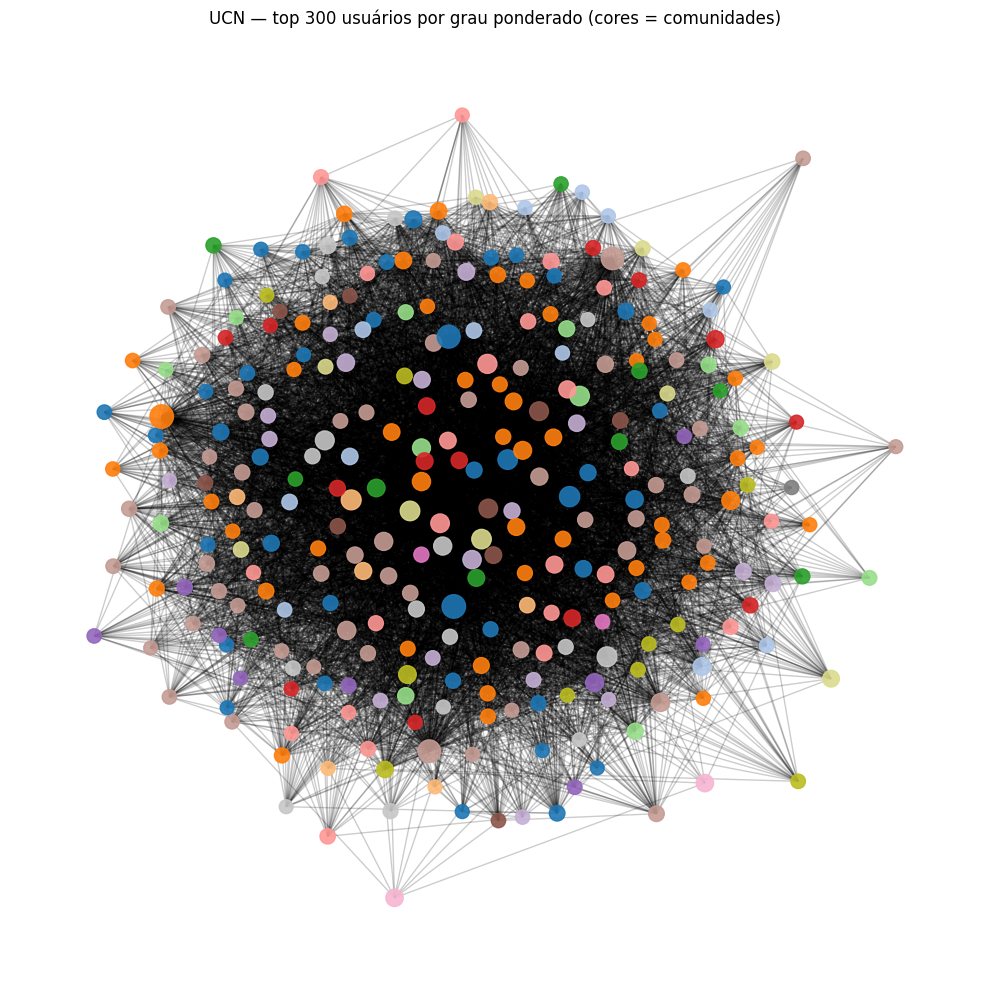

In [31]:
# selecionar subconjunto de nós (ex: top 300 por degree_weighted)
subset_nodes = (
    ucn_nodes.sort_values("degree_weighted", ascending=False)
             .head(300)["user_id"]
             .tolist()
)

H = G_ucn.subgraph(subset_nodes).copy()

# layout Kamada-Kawai
pos = nx.kamada_kawai_layout(H)

# mapear atributos
comm_map = ucn_nodes.set_index("user_id")["community"].to_dict()
deg_map  = ucn_nodes.set_index("user_id")["degree_weighted"].to_dict()

communities = [comm_map[n] for n in H.nodes()]
degrees_w  = np.array([deg_map[n] for n in H.nodes()])

# tamanhos de nó (escala)
node_sizes = 50 + 5 * np.sqrt(degrees_w)

# cores por comunidade
unique_comms = sorted(set(communities))
color_map = {c: cm.tab20(i % 20) for i, c in enumerate(unique_comms)}
node_colors = [color_map[c] for c in communities]

plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(H, pos, alpha=0.2)
nx.draw_networkx_nodes(
    H, pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.9
)
plt.axis("off")
plt.title("UCN — top 300 usuários por grau ponderado (cores = comunidades)")
plt.tight_layout()
plt.savefig("ucn_bubbles_top300.png", dpi=300)
plt.show()


In [32]:
top_groups_deg = (
    gcn_nodes.sort_values("degree_weighted", ascending=False)
             .head(50)
)

top_groups_deg.to_csv("gcn_top50_degree_weighted.csv", index=False, encoding="utf-8")
display(top_groups_deg.head(10))


,group_id,degree,degree_weighted,community
5,ab6b15851eba775fddb0fac2ab1d32b4,214,9723,1
7,04cd2bacf2ef6d56d4e8c0272752bbc0,192,6047,1
6,edcdeceade32db7761bbb5269965c06f,199,5970,1
23,6fb204781074ea35ab1e957ba150c56f,196,5800,1
19,39b271ec422f6c11db3159df72078c6c,189,5670,1
44,64413647daa2460b187cfd1d25f50634,191,5113,1
0,75ac468d11adb71ecdcb5c0ac7d78134,196,5077,1
113,1ae43beb5ef8fadbe7cf31e87faec00c,185,4833,1
4,b5a0f1f01df8b5c052337dccdb4c3d70,195,4379,1
53,b14e237b7d02b836a57692bd2d8fec88,195,4288,1


In [33]:
# dataset preprocessado com datas
df_msgs = pd.read_csv("dataset_zap_1_preprocessado.csv", parse_dates=["date_message"])

# manter apenas colunas relevantes
df_groups_time = df_msgs[["id_group_anonymous", "date_message"]].dropna().copy()

# juntar com comunidades de grupos
df_groups_time = df_groups_time.merge(
    gcn_comms,
    left_on="id_group_anonymous",
    right_on="group_id",
    how="inner"
)

# extrair apenas a data (dia)
df_groups_time["date"] = df_groups_time["date_message"].dt.date

# série temporal: nº de mensagens por comunidade por dia
timeline = (
    df_groups_time.groupby(["community", "date"])
                  .size()
                  .reset_index(name="num_messages")
)

timeline.to_csv("gcn_timeline_community_day.csv", index=False, encoding="utf-8")
display(timeline.head())


,community,date,num_messages
0,0,2022-08-17,9
1,0,2022-08-18,63
2,0,2022-08-19,53
3,0,2022-08-20,30
4,0,2022-08-21,39


Maiores comunidades GCN: [1, 0, 6]


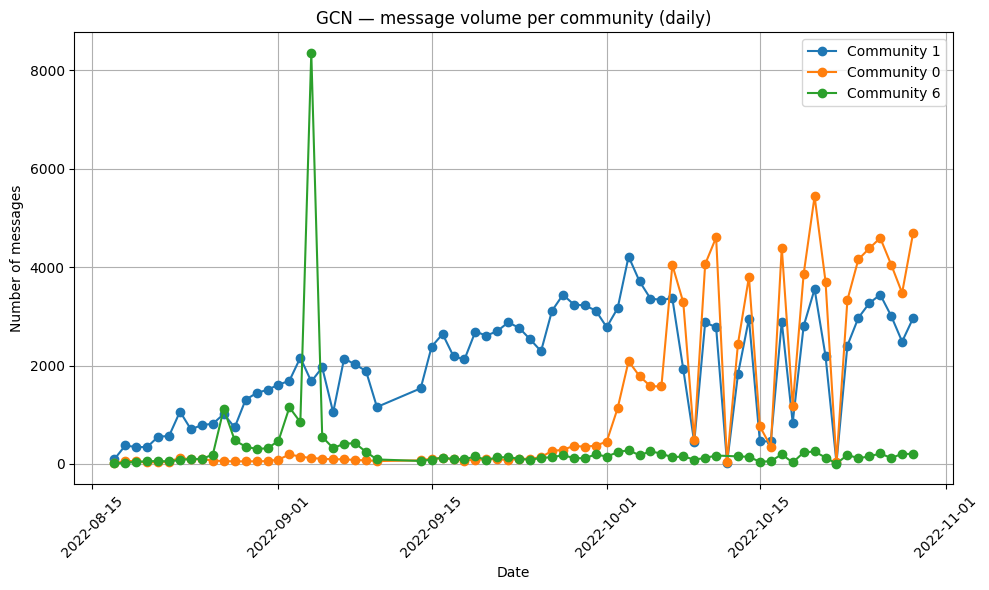

In [34]:
# pegar as 3 maiores comunidades de grupos
comm_sizes_gcn = gcn_nodes["community"].value_counts()
top_comm_gcn = comm_sizes_gcn.head(3).index.tolist()
print("Maiores comunidades GCN:", top_comm_gcn)

plt.figure(figsize=(10, 6))

for c in top_comm_gcn:
    sub = timeline[timeline["community"] == c].sort_values("date")
    plt.plot(sub["date"], sub["num_messages"], marker="o", label=f"Community {c}")

plt.xlabel("Date")
plt.ylabel("Number of messages")
plt.title("GCN — message volume per community (daily)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("gcn_community_timelines.png", dpi=300)
plt.show()


In [49]:
import pandas as pd
from collections import Counter
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# === Carregar comunidades (usuário → comunidade)
df_comm = pd.read_csv("ucn_communities.csv")

# Comunidade alvo
COMM = 6

usuarios_c6 = df_comm[df_comm["community"] == COMM]["user_id"].unique()
print("Usuários na comunidade", COMM, ":", len(usuarios_c6))

# === Carregar dataset de mensagens preprocessadas
df = pd.read_csv("dataset_zap_1_preprocessado.csv")

# manter mensagens desses usuários
df_c6 = df[df["id_member_anonymous"].isin(usuarios_c6)].copy()

print("Total de mensagens da comunidade", COMM, ":", len(df_c6))
df_c6.head()


Usuários na comunidade 6 : 2
Total de mensagens da comunidade 6 : 4


,id,date_message,id_member_anonymous,ddi,ddd,country,country_iso3,state,id_group_anonymous,media,...,messenger,media_name,media_md5,display_name,address_message,latitude_message,longitude_message,contacts_message,tokens_preprocessed,clean_text
107467,1253957,2022-08-27 01:10:56.000000,08ca3e115d169a44e0c65e5c96fc4bb8,55,86,BRAZIL,BRA,PI,631f8a01332e3b0758a3318e5aaa6357,CF62236A39CA194E33DD3F08F2832102.f4v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['divulgado', 'veja', 'ex-presidiário', 'lula'...",divulgado veja ex-presidiário lula lendo respo...
147199,1246517,2022-08-24 17:16:09.000000,08ca3e115d169a44e0c65e5c96fc4bb8,55,86,BRAZIL,BRA,PI,631f8a01332e3b0758a3318e5aaa6357,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['atenção', 'brasil', 'Brazil', 'atenção', 'bo...",atenção brasil Brazil atenção bolsonaristas ra...
151341,1601115,2022-10-10 12:48:52.000000,08ca3e115d169a44e0c65e5c96fc4bb8,55,86,BRAZIL,BRA,PI,631f8a01332e3b0758a3318e5aaa6357,9c96546df446601b96ed39382b5adeb2.f4v,...,whatsapp,NaN,9c96546df446601b96ed39382b5adeb2,NaN,NaN,0.0,0.0,NaN,"['cristã', 'consciente', 'bem', 'articulada', ...",cristã consciente bem articulada espírito sant...
151342,1601117,2022-10-10 12:48:58.000000,db88983eb2d53339caf5ed0b7090c963,55,85,BRAZIL,BRA,CE,02279b9910329ca9ed5890aa58c68400,NaN,...,whatsapp,NaN,NaN,NaN,NaN,0.0,0.0,NaN,"['https', '//folhabv.com.br/noticia/policia/oc...",https //folhabv.com.br/noticia/policia/ocorren...


In [50]:
# pegar todos os tokens já preprocessados
all_tokens = []

for txt in df_c6["clean_text"].astype(str):
    toks = txt.split()
    all_tokens.extend(toks)

# Frequência de tokens
freq = Counter(all_tokens)

print("\nTOP 30 palavras mais frequentes na Comunidade", COMM)
for w, c in freq.most_common(30):
    print(f"{w:20s} {c}")



TOP 30 palavras mais frequentes na Comunidade 6
:Brazil              11
Brazil               2
atenção              2
divulgado            1
veja                 1
ex-presidiário       1
lula                 1
lendo                1
respostas            1
perguntas            1
feitas               1
canalhas             1
jornalistas          1
..                   1
farsa                1
vamos                1
bolsonaro            1
votando              1
keycap_2             1
:keycap_2            1
novamente            1
red_exclamation_mark 1
brasil               1
bolsonaristas        1
raised_fist          1
alerta               1
entrevista           1
luladrão/globolixo   1
face_with_symbols_on_mouth 1
assisti              1


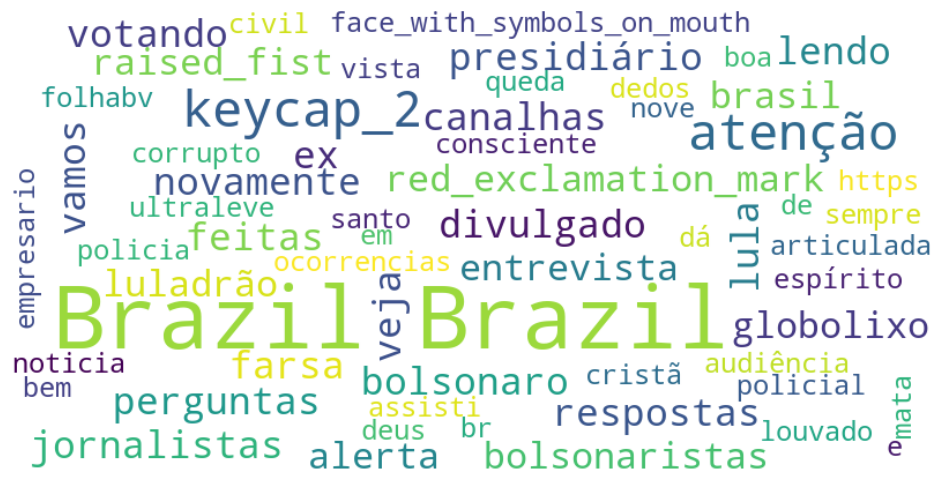

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_tokens))

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


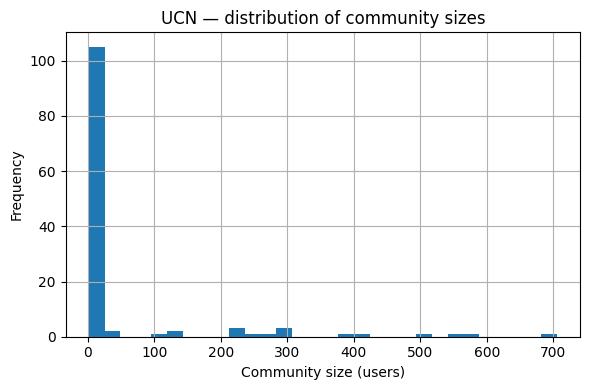

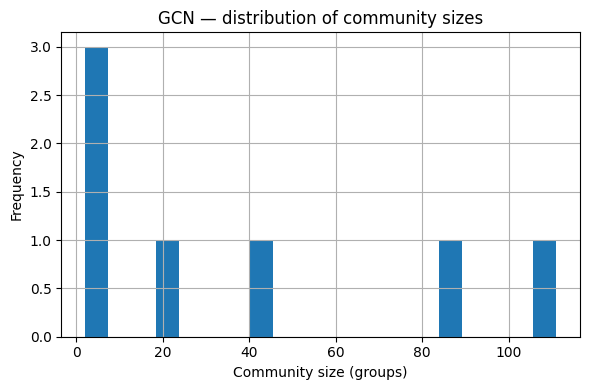

In [35]:
ucn_sizes = pd.read_csv("ucn_community_sizes.csv")  # community, size
gcn_sizes = pd.read_csv("gcn_community_sizes.csv")  # community, size

# UCN
plt.figure(figsize=(6,4))
plt.hist(ucn_sizes["size"], bins=30)
plt.xlabel("Community size (users)")
plt.ylabel("Frequency")
plt.title("UCN — distribution of community sizes")
plt.tight_layout()
plt.savefig("ucn_community_size_distribution.png", dpi=300)
plt.show()

# GCN
plt.figure(figsize=(6,4))
plt.hist(gcn_sizes["size"], bins=20)
plt.xlabel("Community size (groups)")
plt.ylabel("Frequency")
plt.title("GCN — distribution of community sizes")
plt.tight_layout()
plt.savefig("gcn_community_size_distribution.png", dpi=300)
plt.show()


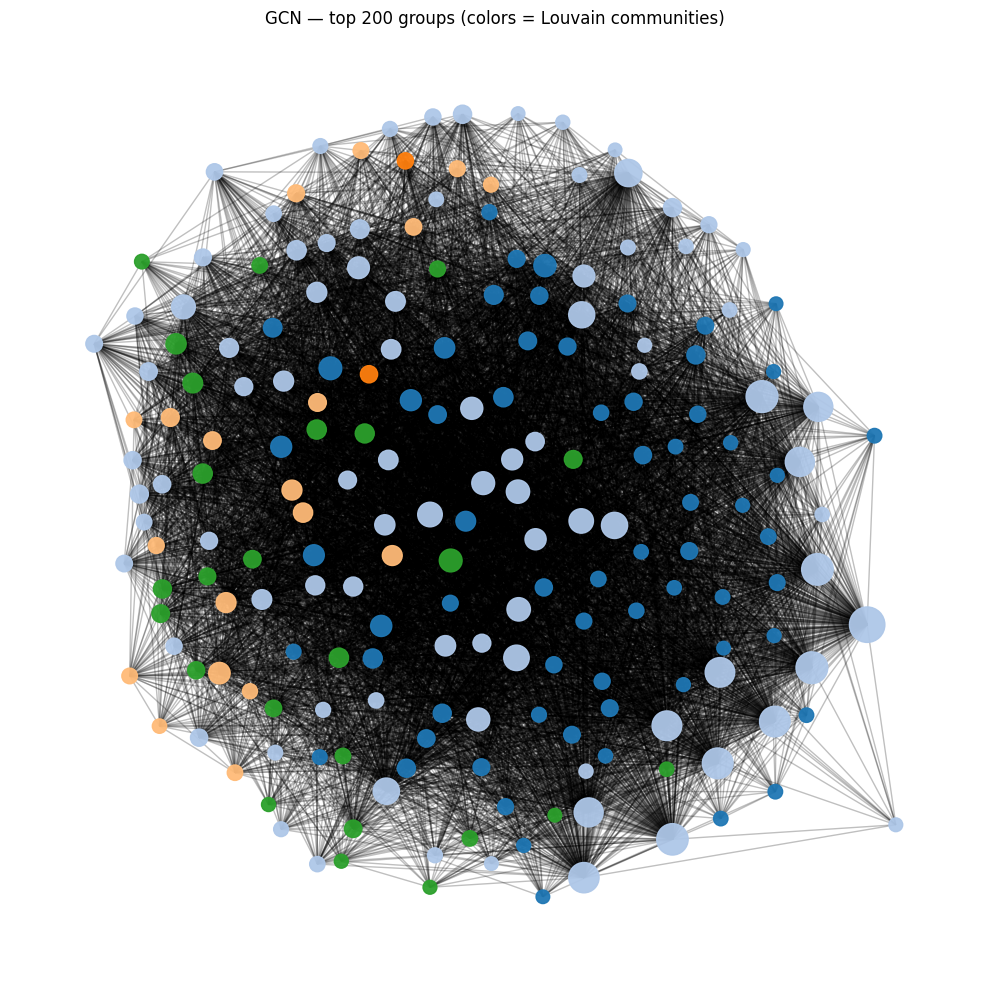

In [36]:
# pegar todos os grupos ou apenas um subconjunto (ex: top 200 por degree)
subset_groups = (
    gcn_nodes.sort_values("degree_weighted", ascending=False)
             .head(200)["group_id"]
             .tolist()
)

H_g = G_gcn.subgraph(subset_groups).copy()
pos_g = nx.kamada_kawai_layout(H_g)

comm_map_g = gcn_nodes.set_index("group_id")["community"].to_dict()
deg_map_g  = gcn_nodes.set_index("group_id")["degree_weighted"].to_dict()

communities_g = [comm_map_g[n] for n in H_g.nodes()]
degw_g       = np.array([deg_map_g[n] for n in H_g.nodes()])
sizes_g      = 60 + 6 * np.sqrt(degw_g)

unique_comms_g = sorted(set(communities_g))
color_map_g = {c: cm.tab20(i % 20) for i, c in enumerate(unique_comms_g)}
colors_g = [color_map_g[c] for c in communities_g]

plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(H_g, pos_g, alpha=0.25)
nx.draw_networkx_nodes(H_g, pos_g, node_size=sizes_g, node_color=colors_g, alpha=0.95)
plt.axis("off")
plt.title("GCN — top 200 groups (colors = Louvain communities)")
plt.tight_layout()
plt.savefig("gcn_bubbles_top200.png", dpi=300)
plt.show()


In [37]:
print(ucn_sizes.sort_values("size", ascending=False).head(10).to_latex(
    index=False,
    caption="Largest communities in the user coordination network (UCN) detected by Louvain.",
    label="tab:ucn_communities"
))

print(gcn_sizes.sort_values("size", ascending=False).head(10).to_latex(
    index=False,
    caption="Largest communities in the group coordination network (GCN) detected by Louvain.",
    label="tab:gcn_communities"
))


\begin{table}
\caption{Largest communities in the user coordination network (UCN) detected by Louvain.}
\label{tab:ucn_communities}
\begin{tabular}{rr}
\toprule
community & size \\
\midrule
21 & 705 \\
16 & 577 \\
2 & 564 \\
26 & 506 \\
5 & 403 \\
92 & 386 \\
25 & 294 \\
46 & 291 \\
23 & 284 \\
119 & 273 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Largest communities in the group coordination network (GCN) detected by Louvain.}
\label{tab:gcn_communities}
\begin{tabular}{rr}
\toprule
community & size \\
\midrule
1 & 111 \\
0 & 85 \\
6 & 44 \\
5 & 22 \\
3 & 3 \\
2 & 2 \\
4 & 2 \\
\bottomrule
\end{tabular}
\end{table}



In [38]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("dataset_zap_1_preprocessado.csv", low_memory=False)

# garantir que a coluna é datetime
df["date_message"] = pd.to_datetime(df["date_message"], errors="coerce")

# remover datas inválidas
df = df.dropna(subset=["date_message"]).copy()

# criar coluna apenas com a data (dia)
df["day"] = df["date_message"].dt.date

print("Intervalo temporal:", df["date_message"].min(), "→", df["date_message"].max())
print("Total de mensagens:", len(df))


Intervalo temporal: 2022-08-17 19:25:29 → 2022-10-29 23:59:16
Total de mensagens: 259650


In [39]:
msg_per_day = df.groupby("day").size().reset_index(name="num_messages")

print(msg_per_day.head())
print("\nDias com mais mensagens:")
display(msg_per_day.sort_values("num_messages", ascending=False).head(10))


          day  num_messages
0  2022-08-17           119
1  2022-08-18           491
2  2022-08-19           462
3  2022-08-20           447
4  2022-08-21           739

Dias com mais mensagens:


,day,num_messages
18,2022-09-04,10225
61,2022-10-20,9387
67,2022-10-26,8388
70,2022-10-29,7972
66,2022-10-25,7942
48,2022-10-07,7664
52,2022-10-11,7656
58,2022-10-17,7652
65,2022-10-24,7358
68,2022-10-27,7313


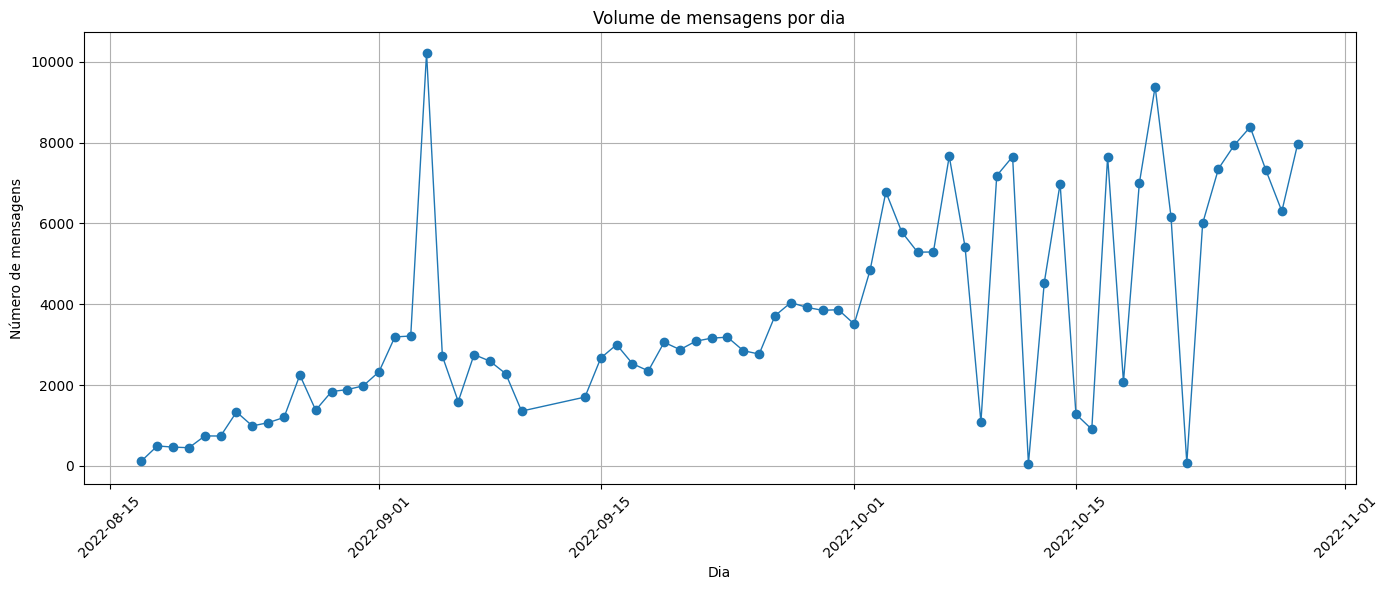

In [40]:
plt.figure(figsize=(14,6))
plt.plot(msg_per_day["day"], msg_per_day["num_messages"], marker="o", linewidth=1)
plt.title("Volume de mensagens por dia")
plt.xlabel("Dia")
plt.ylabel("Número de mensagens")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


In [44]:
eleicao = pd.to_datetime("2022-10-29").date()

mensagens_eleicao = df[df["day"] == eleicao]

print("Total de mensagens no dia da eleição:", len(mensagens_eleicao))
mensagens_eleicao.head()


Total de mensagens no dia da eleição: 7972


,id,date_message,id_member_anonymous,ddi,ddd,country,country_iso3,state,id_group_anonymous,media,...,media_name,media_md5,display_name,address_message,latitude_message,longitude_message,contacts_message,tokens_preprocessed,clean_text,day
248884,1846557,2022-10-29 00:00:02,1d6bf979da320438c41c81835ebddd3d,55,91,BRAZIL,BRA,PA,64413647daa2460b187cfd1d25f50634,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,"['https', '//youtu.be/ywhrowazibu']",https //youtu.be/ywhrowazibu,2022-10-29
248885,1846559,2022-10-29 00:00:12,30ac2f3ff213b5f5b14c25dbfd798177,55,24,BRAZIL,BRA,RJ,addb88a34374d43aa9ecd4df7359ce39,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,"['https', '//youtu.be/swxkgrf2kd4']",https //youtu.be/swxkgrf2kd4,2022-10-29
248886,1846561,2022-10-29 00:00:22,987a6f44eff42028bb414bf4b0c137c4,55,48,BRAZIL,BRA,SC,f482de32942f17e45253b1109d2e1184,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,"['https', '//twitter.com/damadanoite14/status/...",https //twitter.com/damadanoite14/status/15861...,2022-10-29
248887,1846562,2022-10-29 00:00:23,05f680f365e0dbb4b3ca91d214fb31f5,55,49,BRAZIL,BRA,SC,3b1a74af2d51e152b3add47483b1f23e,0b9e15a46eb037616e0edda12477334f.f4v,...,NaN,0b9e15a46eb037616e0edda12477334f,NaN,NaN,0.0,0.0,NaN,['..'],..,2022-10-29
248888,1846563,2022-10-29 00:00:25,3b473d9711618e19e71b682126e80a57,55,11,BRAZIL,BRA,SP,edcdeceade32db7761bbb5269965c06f,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,"['https', '//youtu.be/vykbbkzy2ig']",https //youtu.be/vykbbkzy2ig,2022-10-29


In [45]:
mensagens_eleicao[["date_message", "text_content_anonymous"]].sample(20)


,date_message,text_content_anonymous
253158,2022-10-29 15:26:41,https://vm.tiktok.com/ZMFSV9Sg4/
255196,2022-10-29 19:32:45,https://novaiguacu24h.com.br/declaracao-de-lul...
252378,2022-10-29 09:26:31,https://m.facebook.com/story.php?story_fbid=11...
252870,2022-10-29 14:44:27,"Escute o que Rita Mundim, professora de econom..."
251577,2022-10-29 02:48:05,https://m.facebook.com/story.php?story_fbid=pf...
252745,2022-10-29 14:27:04,Resumo do debate na GloboLixo:\n\n*LULArápio (...
256012,2022-10-29 13:34:19,"https://youtu.be/J7qpX4lDyYw Que coisa linda, ..."
256487,2022-10-29 20:43:44,https://www.facebook.com/groups/jaebolsonaro/p...
254783,2022-10-29 18:36:41,Me diga um líder autoritário que foi benéfico ...
253149,2022-10-29 15:25:29,*Muita gente está falando sobre esta notícia!*...


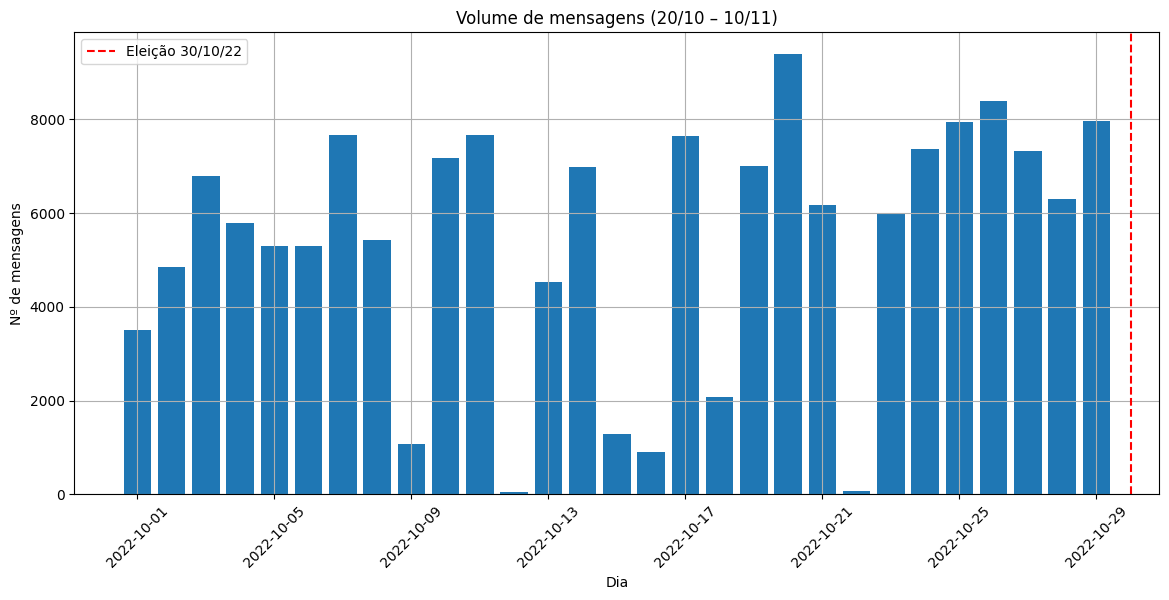

In [47]:
periodo = df[
    (df["day"] >= pd.to_datetime("2022-10-01").date()) &
    (df["day"] <= pd.to_datetime("2022-11-10").date())
]

periodo_count = periodo.groupby("day").size().reset_index(name="num_messages")

plt.figure(figsize=(14,6))
plt.bar(periodo_count["day"], periodo_count["num_messages"])
plt.axvline(pd.to_datetime("2022-10-30"), color="red", linestyle="--", label="Eleição 30/10/22")
plt.title("Volume de mensagens (20/10 – 10/11)")
plt.xlabel("Dia")
plt.ylabel("Nº de mensagens")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [48]:
top3 = msg_per_day.sort_values("num_messages", ascending=False).head(3)
print("Top 3 dias com mais mensagens:")
display(top3)


Top 3 dias com mais mensagens:


,day,num_messages
18,2022-09-04,10225
61,2022-10-20,9387
67,2022-10-26,8388
